# RNN

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np
from matplotlib import pyplot as plt
import random

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

### Data Processing

In [2]:
top_words = 10000

(x_trainval, y_trainval), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=top_words)
# print(x_trainval.shape)
# print(y_trainval.shape)
# print(x_test.shape)
# print(y_test.shape)

In [3]:
# print(x_trainval)
# print(y_trainval)

In [4]:
# wi = tf.keras.datasets.imdb.get_word_index()
# print(wi)

In [5]:
num_classes = 2

x_trainval_long = tf.keras.preprocessing.sequence.pad_sequences(x_trainval, maxlen=160)
x_trainval = tf.keras.preprocessing.sequence.pad_sequences(x_trainval, maxlen=80)
x_test_short = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=40)
x_test_long = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=160)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=80)

# print(x_trainval_long.shape)
# print(x_trainval.shape)
# print(x_test.shape)
# print(x_test_short.shape)
# print(x_test_long.shape)
# print(x_trainval)

In [6]:
x_trainval_long = x_trainval_long.astype("float32")
x_trainval = x_trainval.astype("float32")
x_test = x_test.astype("float32")
x_test_short = x_test_short.astype("float32")
x_test_long = x_test_long.astype("float32")
y_trainval = y_trainval.astype("float32")
y_test = y_test.astype("float32")

indices = np.random.permutation(x_trainval.shape[0])
train_indices = indices[:-5000]
val_indices = indices[-5000:]
x_train = x_trainval[train_indices]
y_train = y_trainval[train_indices]
x_val = x_trainval[val_indices]
y_val = y_trainval[val_indices]

x_train_long = x_trainval_long[train_indices]
x_val_long = x_trainval_long[val_indices]

In [7]:
batch_size=200

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(20000).batch(batch_size).prefetch(1)
train_data_long = tf.data.Dataset.from_tensor_slices((x_train_long, y_train))
train_data_long = train_data_long.shuffle(20000).batch(batch_size).prefetch(1)

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.shuffle(5000).batch(batch_size).prefetch(1)
val_data_long = tf.data.Dataset.from_tensor_slices((x_val_long, y_val))
val_data_long = val_data_long.shuffle(5000).batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.shuffle(25000).batch(batch_size).prefetch(1)
test_data_long = tf.data.Dataset.from_tensor_slices((x_test_long, y_test))
test_data_long = test_data_long.shuffle(25000).batch(batch_size).prefetch(1)
test_data_short = tf.data.Dataset.from_tensor_slices((x_test_short, y_test))
test_data_short = test_data_short.shuffle(25000).batch(batch_size).prefetch(1)

### Define functions for training/testing

In [8]:
def cross_entropy_loss(x,y):
    y = tf.cast(y, tf.int64)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    return tf.reduce_mean(loss)
    
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def Train_model(model, train_data, optimizer, epo, print_loss = True, plot_graph = True):
    step_l = []
    loss_l = []
    
    for epoch in range(0, epo):
        
        running_loss = 0.0
        for step, (batch_x, batch_y) in enumerate(train_data, 1):
            with tf.GradientTape() as g:
                pred = model(batch_x, is_training=True)
                loss = cross_entropy_loss(pred, batch_y)
                
            trainable_variables = model.trainable_variables
            gradients = g.gradient(loss, trainable_variables)
            optimizer.apply_gradients(zip(gradients, trainable_variables))
            
            running_loss += loss.numpy()
            if plot_graph:
                if step % 10 == 0:
                    step_l.append(epoch*250 + step)
                    loss_l.append(running_loss/10)
                    running_loss=0.0
        if print_loss:
            print("epoch : ", epoch+1, "loss: ", loss.numpy())
            
    if plot_graph:
        plt.plot(step_l, loss_l)
    return model

def accuracy_batch(model, test_data):
    acc = 0.
    for step, (batch_x, batch_y) in enumerate(test_data, 1):
        pred = model(batch_x, is_training=False)
        acc += accuracy(pred, batch_y)
    acc = acc/step * 100.
    return acc

In [9]:
import sys
import copy

def early_stopping(model, train_data, val_data, optimizer):
    el = []
    vll = []
    
    p = 4
    i = 0 
    j = 0
    v = sys.float_info.max
    i_s = i
    model_s = copy.deepcopy(model)
    
    while j < p :
        model = Train_model(model, train_data, optimizer, 1, print_loss = False, plot_graph=False)
#         model = Train_model(model, lr, 1, print_loss = False, plot_graph=False)
        
        acc = 0
        for step, (batch_x, batch_y) in enumerate(val_data, 1):
            pred = model(batch_x, is_training=False)
            acc += accuracy(pred, batch_y)
            
        acc = 100.*acc/step
        error = 100.-acc
        
        i = i+1
        print("epoch reached ", i, "val_error = ", error.numpy(), "/smallest_error = ", v)
        temp_v = error.numpy()
        el.append(i)
        vll.append(error)
        if temp_v < v:
            j = 0
            model_s = copy.deepcopy(model)
            i_s = i
            v = temp_v
        else :
            j = j+1
            
    plt.plot(el, vll)
    print("best epoch = ", i_s)
    return model_s, i_s

## Classify IMDB Data with RNN

In [10]:
class RNN(Model):
    def __init__(self):
        super(RNN, self).__init__()
        self.embedding = layers.Embedding(top_words, 100)
        self.rnn = layers.SimpleRNN(64)
        self.out = layers.Dense(num_classes)
        
    def call(self, x, is_training=False):
        x = self.embedding(x)
        x = self.rnn(x)
        x = self.out(x)
        if not is_training:
            x = tf.nn.softmax(x)
        return x

epoch :  1 loss:  0.69185555
epoch :  2 loss:  0.6644394
epoch :  3 loss:  0.59561384
epoch :  4 loss:  0.36953887
epoch :  5 loss:  0.3084674


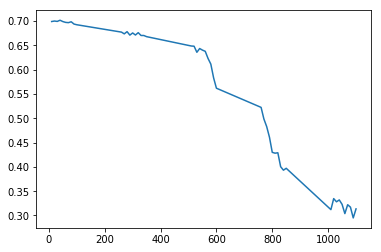

In [13]:
rnn = RNN()
optimizer = tf.optimizers.Adam(0.0001)
rnn = Train_model(rnn, train_data, optimizer, 5)

In [14]:
rnn_acc = accuracy_batch(rnn, test_data).numpy()
print(rnn_acc)

81.048004


In [15]:
rnn_short_acc = accuracy_batch(rnn, test_data_short).numpy()
print(rnn_short_acc)

rnn_long_acc = accuracy_batch(rnn, test_data_long).numpy()
print(rnn_long_acc)

76.23999
83.74396


## Variation of RNN

### LSTM

In [17]:
class LSTM(Model):
    def __init__(self):
        super(LSTM, self).__init__()
        self.embedding = layers.Embedding(top_words, 100)
        self.lstm = layers.LSTM(64)
        self.out = layers.Dense(num_classes)
        
    def call(self, x, is_training=False):
        x = self.embedding(x)
        x = self.lstm(x)
        x = self.out(x)
        if not is_training:
            x = tf.nn.softmax(x)
        return x

epoch :  1 loss:  0.68555564
epoch :  2 loss:  0.47821274
epoch :  3 loss:  0.41108775
epoch :  4 loss:  0.38098305
epoch :  5 loss:  0.305698


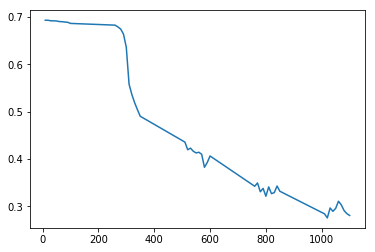

In [18]:
lstm = LSTM()
optimizer = tf.optimizers.Adam(0.0001)
lstm = Train_model(lstm, train_data, optimizer, 5)

In [19]:
lstm_acc = accuracy_batch(lstm, test_data).numpy()
print(lstm_acc)

82.21198


epoch :  1 loss:  0.6757204
epoch :  2 loss:  0.40880778
epoch :  3 loss:  0.30766973
epoch :  4 loss:  0.27681676
epoch :  5 loss:  0.17192389
epoch :  6 loss:  0.25156602


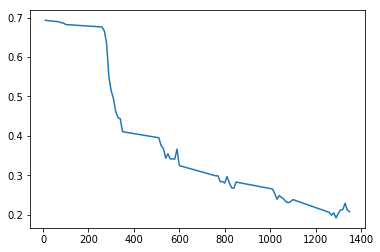

In [22]:
lstm_long = LSTM()
optimizer = tf.optimizers.Adam(0.0001)
lstm_long = Train_model(lstm_long, train_data_long, optimizer, 6)

In [23]:
lstm_acc_long = accuracy_batch(lstm_long, test_data_long).numpy()
print(lstm_acc_long)

85.483986


epoch :  1 loss:  0.44824454
epoch :  2 loss:  0.32238835
epoch :  3 loss:  0.23428804
epoch :  4 loss:  0.2407472


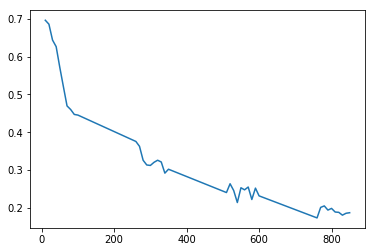

In [24]:
rnn_long = RNN()
rnn_long = Train_model(rnn_long, train_data_long, optimizer, 4)

In [25]:
rnn_acc_long = accuracy_batch(rnn_long, test_data_long).numpy()
print(rnn_acc_long)

84.99602


In [37]:
class Multi_LSTM(Model):
    def __init__(self):
        super(Multi_LSTM, self).__init__()
        self.embedding = layers.Embedding(top_words, 100)
        self.lstm1 = layers.LSTM(64, return_sequences=True)
        self.lstm2 = layers.LSTM(64)
        self.out = layers.Dense(num_classes)
        
    def call(self, x, is_training=False):
#         print(x.shape)
        x = self.embedding(x)
#         print(x.shape)
        x = self.lstm1(x)
#         print(x.shape)
        x = self.lstm2(x)
#         print(x.shape)
        x = self.out(x)
#         print(x.shape)
        if not is_training:
            x = tf.nn.softmax(x)
        return x

In [32]:
model = LSTM()
x = tf.ones((200, 80))

out = model(x, is_training=False)

(200, 80)
(200, 80, 100)
(200, 80, 64)
(200, 64)
(200, 2)


epoch :  1 loss:  0.4089341
epoch :  2 loss:  0.28792018
epoch :  3 loss:  0.23864248
epoch :  4 loss:  0.19734667


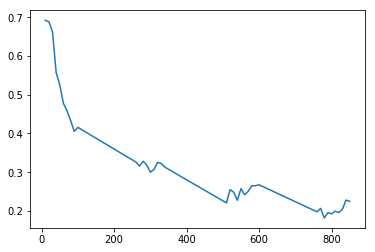

In [38]:
multi_lstm = Multi_LSTM()
multi_lstm = Train_model(multi_lstm, train_data, optimizer, 4)

In [39]:
multi_lstm_acc = accuracy_batch(multi_lstm, test_data).numpy()
print(multi_lstm_acc)

82.004


## Bidirectional LSTM

In [42]:
class BI_LSTM(Model):
    def __init__(self):
        super(BI_LSTM, self).__init__()
        self.embedding = layers.Embedding(top_words, 100)
        lstm_fw = layers.LSTM(64)
        lstm_bw = layers.LSTM(64, go_backwards=True)
        self.bi_lstm = layers.Bidirectional(lstm_fw, backward_layer=lstm_bw)
        self.out = layers.Dense(num_classes)
        
    def call(self, x, is_training=False):
        x = self.embedding(x)
        x = self.bi_lstm(x)
        x = self.out(x)
        if not is_training:
            x = tf.nn.softmax(x)
        return x

epoch :  1 loss:  0.46103698
epoch :  2 loss:  0.28605598
epoch :  3 loss:  0.19772334
epoch :  4 loss:  0.21495146


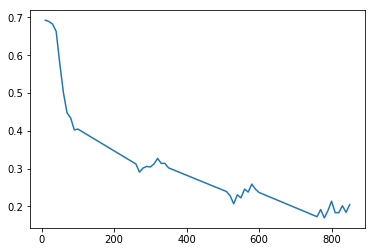

In [43]:
bi_lstm = BI_LSTM()
bi_lstm = Train_model(bi_lstm, train_data, optimizer, 4)

In [44]:
bi_lstm_acc = accuracy_batch(bi_lstm, test_data).numpy()
print(bi_lstm_acc)

83.24401
